In [1]:
import pandas as pd
data=pd.read_csv('Data.csv')
data.drop(columns=['label'], inplace=True)
print(data)
print(data.shape)

                                                Reviews
0     Okay, so I'm not a big video game buff, but wa...
1     The premise of this movie has been tickling my...
2     Jim Carrey is back to much the same role that ...
3     I read several mixed reviews and several of th...
4     Warning: Does contain spoilers.<br /><br />Ope...
...                                                 ...
7495  It was great to see some of my favorite stars ...
7496  2 stars for Kay Francis -- she's wonderful! An...
7497  I really wish i could give this a negative vot...
7498  I love B movies..but come on....this wasn't ev...
7499  As I said in my comment about the first part: ...

[7500 rows x 1 columns]
(7500, 1)


In [2]:
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import contractions
import swifter

def tosentences(article):
    sentences=article.split(". ")
    sentences=[sentence.strip() for sentence in sentences]
    return sentences

In [3]:
def preprocess(sentences, min_word_length=2):
    preprocessed_sentences = []
    for sentence in sentences:
        soup = BeautifulSoup(sentence, 'html.parser')
        sentence = soup.get_text()
        sentence = contractions.fix(sentence)
        words = word_tokenize(sentence)
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words]
        words = [re.sub(r'\d+', '', word) for word in words]  
        words = [re.sub(r'\d', '', word) for word in words]   
        words = [re.sub(r'(.)\1+', r'\1\1', word) for word in words] 
        words = [re.sub(r'\{.*?\}', '', word) for word in words] 
        words = [re.sub(r'^[\'\s]*|[^\w\s\'-]', '', word) for word in words] 
        words = [re.sub(r'\.{3,}', '', word) for word in words]  
        words = [re.sub(r'\.{4,}', '', word) for word in words]  
        words = [re.sub(r'\.( +)', '.', word) for word in words] 
        words = [word for word in words if len(word) >= min_word_length and not word.isnumeric() and word not in string.punctuation]
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        preprocessed_sentence = ' '.join(words)
        preprocessed_sentences.append(preprocessed_sentence)
    
    return preprocessed_sentences

In [4]:
def wordtokenize(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence.lower())
        tokenized_sentences.append(words)
    return tokenized_sentences

In [61]:
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from gensim.models import LsiModel

def train(row):
    tokenized_sentences = [word_tokenize(sentence) for sentence in row['processed']]
    dictionary = corpora.Dictionary(tokenized_sentences)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_sentences]
    lsa_model = LsiModel(corpus, id2word=dictionary, num_topics=12)
    sentence_topic_distributions = []
    for doc in corpus:
        sentence_topic_distribution = lsa_model[doc]
        sentence_topic_distributions.append(dict(sentence_topic_distribution))
    topic_words_list = []
    for idx, topic in lsa_model.print_topics(-1):
        topic_words = [word for word, _ in lsa_model.show_topic(idx)]
        topic_words_list.append(topic_words)
    row['topic_words'] = topic_words_list
    row['sentence_topic_distributions'] = sentence_topic_distributions
    return row

In [6]:
import ast
import swifter

def filter_topic_distribution(distribution_list):
    theta = 0.1
    t1_list = []
 
    for distribution in distribution_list:
        filtered_distribution = [{k: v} for k, v in distribution.items() if v > theta]
        t1_list.extend(filtered_distribution)
    return t1_list

In [7]:
def get_dominant_topics(sentence_topic_distribution):
    dominant_topics = []
    for distribution in sentence_topic_distribution:
        dominant_topic = max(distribution, key=distribution.get)
        dominant_topics.append(dominant_topic)
    return dominant_topics

In [8]:
def get_topic_words(row):
    index_values = row['ST']
    topic_words = row['topic_words']
    result = []
    for index in index_values:
        if 0 <= index < len(topic_words):
            result.append(topic_words[index])
        else:
            result.append(None) 
    return result

In [9]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from senticnet.senticnet import SenticNet
sid = SentimentIntensityAnalyzer()
sn = SenticNet()


def sentic(word):
     score=0
     if word in sn.data:
        sentiment_info = sn.concept(word)
        score = float(sentiment_info.get('polarity_value', 0))
     return score

def TEXTBLOB(word):  
    sentiment_score=TextBlob(word).sentiment.polarity
    return sentiment_score

def SA(word):
     sentiment_score = sid.polarity_scores(word)['compound'] 
     return sentiment_score
  
def match_and_calculate_sentiment(sentences, topic_words):
    sentiment_scores = []
    
    for sentence, words in zip(sentences, topic_words):
        sentiment_score=0
        for word in nltk.word_tokenize(sentence):
            if word in words:
                sentiment_score += (TEXTBLOB(word))
        sentiment_scores.append(sentiment_score)
        
    return sentiment_scores

In [10]:
def calculate_reaching_definition(df,r):
    definitions_generated = []
    definitions_killed = []
    
    for index, row in df.iterrows():
        row_definitions_generated = [set() for _ in range(len(row['processed']))]
        row_definitions_killed = [set() for _ in range(len(row['processed']))]
        
        for i, (sentence, topic_idx, sentiment_score) in enumerate(zip(row['processed'], row['ST'], row[r])):
            definition_generated = (topic_idx, sentiment_score)
            for j in range(i):
                if (row['ST'][j], row[r][j]) == definition_generated:
                    row_definitions_killed[i].add(j)
            row_definitions_generated[i].add(definition_generated)
            for j in range(i):
                if j not in row_definitions_killed[i]:
                    row_definitions_generated[i] |= row_definitions_generated[j]
        
        definitions_generated.append(row_definitions_generated)
        definitions_killed.append(row_definitions_killed)
    
    df['definitions_generated'] = definitions_generated
    df['definitions_killed'] = definitions_killed
    
    return df

In [11]:
def calculate_IN_OUT_sets(definitions_generated_col, definitions_killed_col):
    IN_sets = []
    OUT_sets = []
    for gen, killed in zip(definitions_generated_col, definitions_killed_col):
        OUT = [set() for _ in range(len(gen))]
        changed = True
        while changed:
            changed = False
            for i in range(len(gen)):
                IN = set().union(*[OUT[p] for p in range(len(gen)) if i not in killed[p]])
                new_OUT = gen[i].union(IN - killed[i])
                if new_OUT != OUT[i]:
                    OUT[i] = new_OUT
                    changed = True
        IN = [set().union(*[OUT[p] for p in range(len(gen)) if i in gen[p]]) for i in range(len(gen))]
        IN_sets.append(IN)
        OUT_sets.append(OUT)
    return IN_sets, OUT_sets

In [12]:
def generate_summary(sentences, S, sentiment_scores):
    summaries = []

    for doc_sentences, out, doc_sentiment_scores in zip(sentences, S, sentiment_scores):
        summary = ""
        added_indices = set()

        for out_set in out:
            for j in out_set:
                if isinstance(j, tuple):
                    j = j[0]
                j = int(j)  
                if 0 <= j < len(doc_sentences) and j < len(doc_sentiment_scores):
                    if j not in added_indices:
                        summary += doc_sentences[j] + " "
                        added_indices.add(j)

        summaries.append(summary.strip())

    return summaries

In [13]:
from bs4 import BeautifulSoup
import contractions
import re
def preprocess_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    text = contractions.fix(text)
    text = re.sub(r'\\', '', text)
    return text

In [14]:
def classify_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'postive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
#for 10 topics

In [15]:
data['sentence']=data['Reviews'].swifter.apply(tosentences)
data['processed'] = data['sentence'].swifter.apply(preprocess)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

C:\Users\akvnr\AppData\Local\Temp\ipykernel_14808\1479389325.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence, 'html.parser')


In [23]:
Iter = data.swifter.apply(train, axis=1)
Iter.head(3)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

,Reviews,sentence,processed,topic_words,sentence_topic_distributions
0,"Okay, so I'm not a big video game buff, but wa...","[Okay, so I'm not a big video game buff, but w...",[Okay big video game buff game House Dead real...,"[[movie, game, kid, video, Dead, House, dozen,...","[{0: -9.563340356132773, 1: 2.306408936935482,..."
1,The premise of this movie has been tickling my...,[The premise of this movie has been tickling m...,[premise movie tickling imagination quite time...,"[[film, Nothing, movie, one, Andrew, still, en...","[{0: 0.40495483402481525, 1: -0.45042548266611..."
2,Jim Carrey is back to much the same role that ...,[Jim Carrey is back to much the same role that...,[Jim Carrey back much role played Mask timid g...,"[[scene, Bruce, film, movie, one, comedy, news...","[{0: -0.3012661348922372, 1: 0.440155869681068..."


In [24]:
Iter.to_csv('T10.csv')

In [25]:
Iter['DTC'] = Iter['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

In [26]:
Iter['ST']=Iter['DTC'].swifter.apply(get_dominant_topics)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

In [27]:
Iter['ATW'] = Iter.apply(get_topic_words, axis=1)

In [28]:
Iter['sentiment_score'] = Iter.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)

In [29]:
df=calculate_reaching_definition(Iter,'sentiment_score')

In [30]:
IN_sets, OUT_sets = calculate_IN_OUT_sets(df['definitions_generated'], df['definitions_killed'])

In [31]:
S = [0] * len(OUT_sets)
for i, out_set in enumerate(OUT_sets):
    S[i] = list(out_set)[-1] if out_set else None

print("Output definition of the last node:", S[1])

Output definition of the last node: {(4, 0.0), (7, 0), (8, 0), (1, 0.0), (4, 0.4), (9, 0.0), (0, 0.0), (2, 0.0), (3, 0.0), (5, 0.0), (0, 0.2), (6, 0)}


In [35]:
summaries= generate_summary(Iter['sentence'], S, Iter['sentiment_score'])
summary_df = pd.DataFrame({'Summary': summaries})
print("Summary DataFrame:")
print(summary_df)

Summary DataFrame:
                                                Summary
0     I can't stand it when well-known actors change...
1     That alone is the main reason to why these two...
2     Needless to say, he loses his temper on live T...
3     Just for reference, I recently watched 'The We...
4     His name was Mr Warning: Does contain spoilers...
...                                                 ...
7495  Five years later, Bogdanovich's ex-girlfriend,...
7496  The hubby's biddy of a mother puts a bug in hu...
7497  Terribly acted, directed, written, etc etc I r...
7498  I love B movies..but come on....this wasn't ev...
7499  As I said in my comment about the first part: ...

[7500 rows x 1 columns]


In [36]:
summary_df['Summary']=summary_df['Summary'].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

C:\Users\akvnr\AppData\Local\Temp\ipykernel_14808\1463473490.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [38]:
summary_df.to_csv('TWLSA10.csv')

In [39]:
Iter['TBLabel']=Iter['Reviews'].swifter.apply( classify_sentiment)
summary_df['TBLabel']=summary_df['Summary'].swifter.apply( classify_sentiment)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

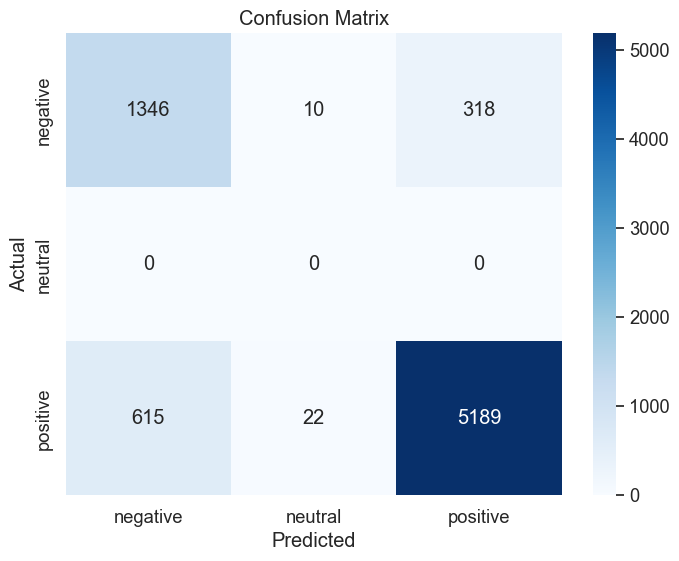

Accuracy: 0.8713333333333333
Precision: 0.8851449458002874
Recall: 0.8713333333333333
F1-score: 0.8766381975681541


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

actual = Iter['TBLabel']
predicted = summary_df['TBLabel']
label =['negative','neutral','positive']
cm = confusion_matrix(actual, predicted)
labels = np.unique(actual)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy0 = accuracy_score(actual, predicted)
precision0 = precision_score(actual, predicted, average='weighted')
recall0 = recall_score(actual, predicted, average='weighted')
f10 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy0)
print("Precision:", precision0)
print("Recall:", recall0)
print("F1-score:", f10)

In [ ]:
#for 9 Topics

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

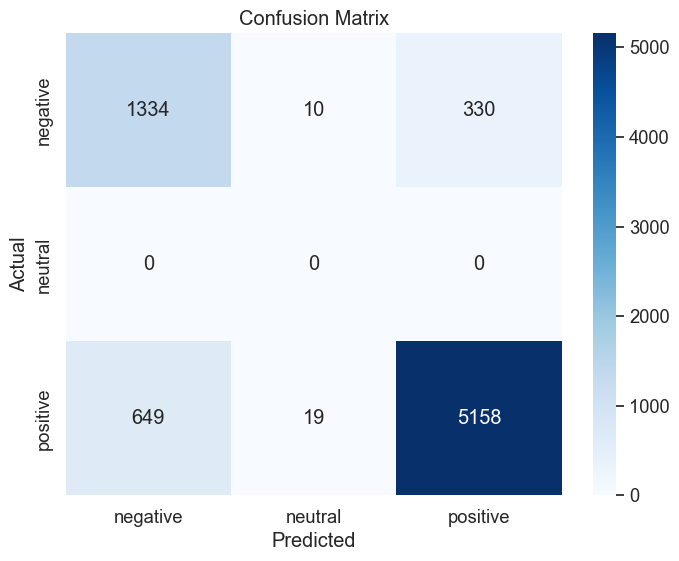

Accuracy: 0.8656
Precision: 0.8802407682502438
Recall: 0.8656
F1-score: 0.8711167529959544


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
Iter1 = data.swifter.apply(train, axis=1)
Iter1.to_csv('T9.csv')
Iter1['DTC'] = Iter1['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter1['ST']=Iter1['DTC'].swifter.apply(get_dominant_topics)
Iter1['ATW'] = Iter1.swifter.apply(get_topic_words, axis=1)
Iter1['sentiment_score'] = Iter1.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df1=calculate_reaching_definition(Iter1,'sentiment_score')
IN_sets1, OUT_sets1 = calculate_IN_OUT_sets(df1['definitions_generated'], df1['definitions_killed'])

S0 = [0] * len(OUT_sets1)
for i, out_set in enumerate(OUT_sets1):
    S0[i] = list(out_set)[-1] if out_set else None

summaries1 = generate_summary(Iter1['sentence'], S0, Iter1['sentiment_score'])
summary_df1 = pd.DataFrame({'Summary': summaries1})

Iter1['TBLabel']=Iter1['Reviews'].swifter.apply( classify_sentiment)
summary_df1['TBLabel']=summary_df1['Summary'].swifter.apply( classify_sentiment)

summary_df1.to_csv('TWLSA9.csv')

actual = Iter1['TBLabel']
predicted = summary_df1['TBLabel']
label =['negative','neutral','positive']
cm = confusion_matrix(actual, predicted)
labels = np.unique(actual)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy9 = accuracy_score(actual, predicted)
precision9 = precision_score(actual, predicted, average='weighted')
recall9 = recall_score(actual, predicted, average='weighted')
f19 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy9)
print("Precision:", precision9)
print("Recall:", recall9)
print("F1-score:", f19)

In [ ]:
#for 8 topics

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

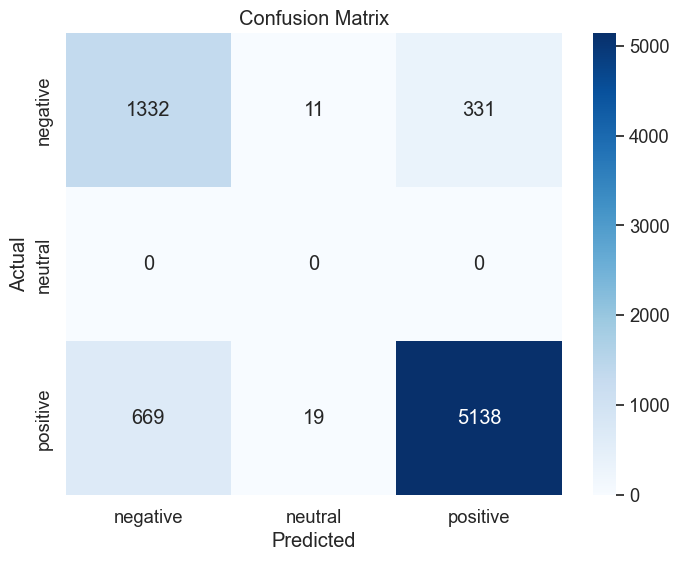

Accuracy: 0.8626666666666667
Precision: 0.8783626859088284
Recall: 0.8626666666666667
F1-score: 0.8685167286951966


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
Iter2 = data.swifter.apply(train, axis=1)
Iter2.to_csv('T8.csv')
Iter2['DTC'] = Iter2['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter2['ST']=Iter2['DTC'].swifter.apply(get_dominant_topics)
Iter2['ATW'] = Iter2.swifter.apply(get_topic_words, axis=1)
Iter2['sentiment_score'] = Iter2.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df2=calculate_reaching_definition(Iter2,'sentiment_score')
IN_sets2, OUT_sets2 = calculate_IN_OUT_sets(df2['definitions_generated'], df2['definitions_killed'])

S1 = [0] * len(OUT_sets2)
for i, out_set in enumerate(OUT_sets2):
    S1[i] = list(out_set)[-1] if out_set else None

summaries2 = generate_summary(Iter2['sentence'], S1, Iter2['sentiment_score'])
summary_df2 = pd.DataFrame({'Summary': summaries2})

Iter2['TBLabel']=Iter2['Reviews'].swifter.apply( classify_sentiment)
summary_df2['TBLabel']=summary_df2['Summary'].swifter.apply( classify_sentiment)

summary_df2.to_csv('TWLSA8.csv')

actual = Iter2['TBLabel']
predicted = summary_df2['TBLabel']
label =['negative','neutral','positive']
cm = confusion_matrix(actual, predicted)
labels = np.unique(actual)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy8 = accuracy_score(actual, predicted)
precision8 = precision_score(actual, predicted, average='weighted')
recall8 = recall_score(actual, predicted, average='weighted')
f18 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy8)
print("Precision:", precision8)
print("Recall:", recall8)
print("F1-score:", f18)

In [ ]:
#for 7 Topics

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

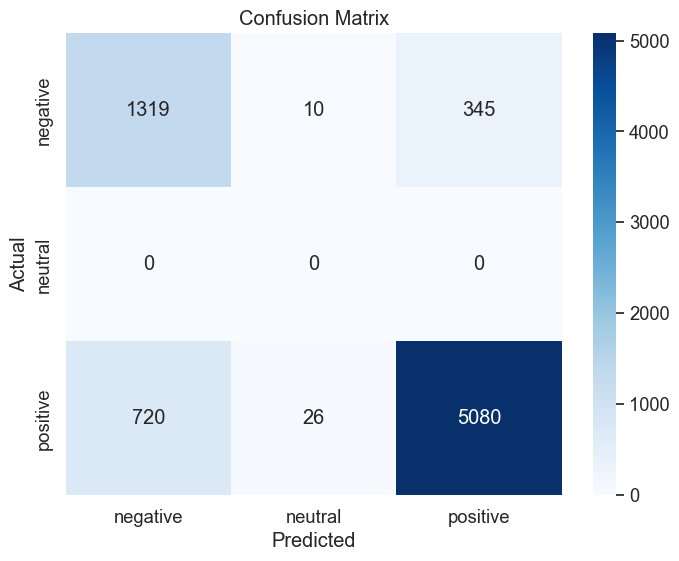

Accuracy: 0.8532
Precision: 0.8717847102243577
Recall: 0.8532
F1-score: 0.8600527580503181


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
Iter3 = data.swifter.apply(train, axis=1)
Iter3.to_csv('T7.csv')
Iter3['DTC'] = Iter3['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter3['ST']=Iter3['DTC'].swifter.apply(get_dominant_topics)
Iter3['ATW'] = Iter3.swifter.apply(get_topic_words, axis=1)
Iter3['sentiment_score'] = Iter3.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df3=calculate_reaching_definition(Iter3,'sentiment_score')
IN_sets3, OUT_sets3 = calculate_IN_OUT_sets(df3['definitions_generated'], df3['definitions_killed'])

S2 = [0] * len(OUT_sets3)
for i, out_set in enumerate(OUT_sets3):
    S2[i] = list(out_set)[-1] if out_set else None

summaries3 = generate_summary(Iter3['sentence'], S2, Iter3['sentiment_score'])
summary_df3 = pd.DataFrame({'Summary': summaries3})

Iter3['TBLabel']=Iter3['Reviews'].swifter.apply( classify_sentiment)
summary_df3['TBLabel']=summary_df3['Summary'].swifter.apply( classify_sentiment)

summary_df3.to_csv('TWLSA7.csv')

actual = Iter3['TBLabel']
predicted = summary_df3['TBLabel']
label =['negative','neutral','positive']
cm = confusion_matrix(actual, predicted)
labels = np.unique(actual)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy7 = accuracy_score(actual, predicted)
precision7 = precision_score(actual, predicted, average='weighted')
recall7 = recall_score(actual, predicted, average='weighted')
f17 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy7)
print("Precision:", precision7)
print("Recall:", recall7)
print("F1-score:", f17)

In [ ]:
# for 6 Topics

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

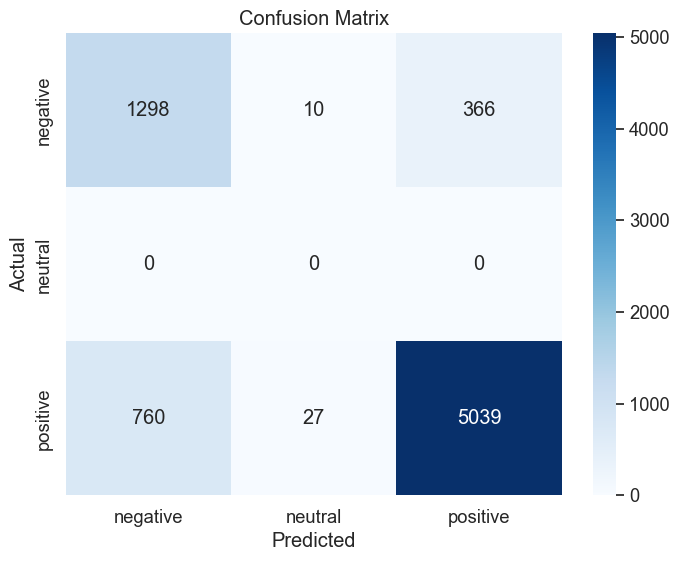

Accuracy: 0.8449333333333333
Precision: 0.8649732709428426
Recall: 0.8449333333333333
F1-score: 0.8523111094951074


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
Iter4 = data.swifter.apply(train, axis=1)
Iter4.to_csv('T6.csv')
Iter4['DTC'] = Iter4['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter4['ST']=Iter4['DTC'].swifter.apply(get_dominant_topics)
Iter4['ATW'] = Iter4.swifter.apply(get_topic_words, axis=1)
Iter4['sentiment_score'] = Iter4.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df4=calculate_reaching_definition(Iter4,'sentiment_score')
IN_sets4, OUT_sets4 = calculate_IN_OUT_sets(df4['definitions_generated'], df4['definitions_killed'])

S3 = [0] * len(OUT_sets4)
for i, out_set in enumerate(OUT_sets4):
    S3[i] = list(out_set)[-1] if out_set else None

summaries4 = generate_summary(Iter4['sentence'], S3, Iter4['sentiment_score'])
summary_df4 = pd.DataFrame({'Summary': summaries4})

Iter4['TBLabel']=Iter4['Reviews'].swifter.apply( classify_sentiment)
summary_df4['TBLabel']=summary_df4['Summary'].swifter.apply( classify_sentiment)

summary_df4.to_csv('TWLSA6.csv')

actual = Iter4['TBLabel']
predicted = summary_df4['TBLabel']
label =['negative','neutral','positive']
cm = confusion_matrix(actual, predicted)
labels = np.unique(actual)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy6 = accuracy_score(actual, predicted)
precision6 = precision_score(actual, predicted, average='weighted')
recall6 = recall_score(actual, predicted, average='weighted')
f16 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy6)
print("Precision:", precision6)
print("Recall:", recall6)
print("F1-score:", f16)

In [ ]:
# For 5 Topics 

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

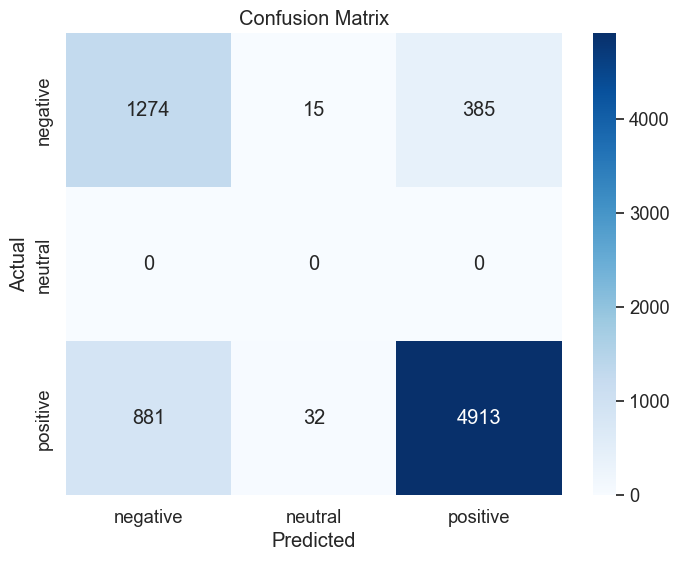

Accuracy: 0.8249333333333333
Precision: 0.8523028852458443
Recall: 0.8249333333333333
F1-score: 0.8346873378836673


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
Iter5 = data.swifter.apply(train, axis=1)
Iter5.to_csv('T5.csv')
Iter5['DTC'] = Iter5['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter5['ST']=Iter5['DTC'].swifter.apply(get_dominant_topics)
Iter5['ATW'] = Iter5.swifter.apply(get_topic_words, axis=1)
Iter5['sentiment_score'] = Iter5.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df5=calculate_reaching_definition(Iter5,'sentiment_score')
IN_sets5, OUT_sets5 = calculate_IN_OUT_sets(df5['definitions_generated'], df5['definitions_killed'])

S4 = [0] * len(OUT_sets5)
for i, out_set in enumerate(OUT_sets5):
    S4[i] = list(out_set)[-1] if out_set else None

summaries5 = generate_summary(Iter5['sentence'], S4, Iter5['sentiment_score'])
summary_df5 = pd.DataFrame({'Summary': summaries5})

Iter5['TBLabel']=Iter5['Reviews'].swifter.apply( classify_sentiment)
summary_df5['TBLabel']=summary_df5['Summary'].swifter.apply( classify_sentiment)

summary_df5.to_csv('TWLSA5.csv')

actual = Iter5['TBLabel']
predicted = summary_df5['TBLabel']
label =['negative','neutral','positive']
cm = confusion_matrix(actual, predicted)
labels = np.unique(actual)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy5 = accuracy_score(actual, predicted)
precision5 = precision_score(actual, predicted, average='weighted')
recall5 = recall_score(actual, predicted, average='weighted')
f15 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy5)
print("Precision:", precision5)
print("Recall:", recall5)
print("F1-score:", f15)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

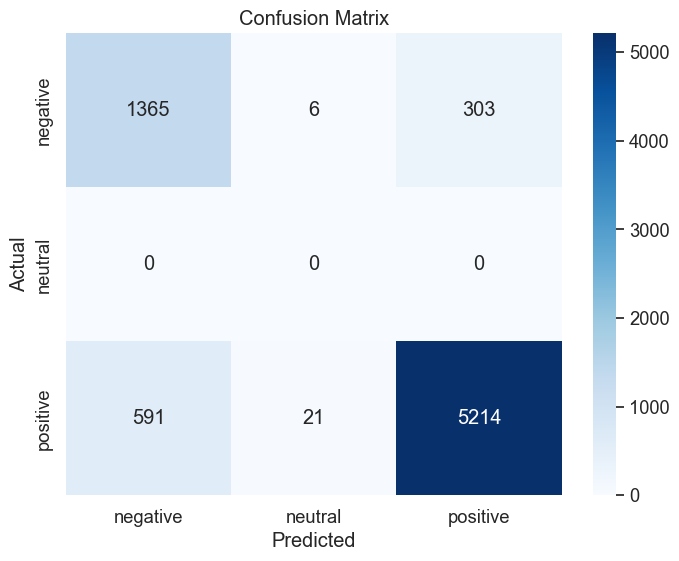

Accuracy: 0.8772
Precision: 0.8898979847009412
Recall: 0.8772
F1-score: 0.8819994273236561


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
Iter11 = data.swifter.apply(train, axis=1)
Iter11.to_csv('T11.csv')
Iter11['DTC'] = Iter11['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter11['ST']=Iter11['DTC'].swifter.apply(get_dominant_topics)
Iter11['ATW'] = Iter11.swifter.apply(get_topic_words, axis=1)
Iter11['sentiment_score'] = Iter11.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df11=calculate_reaching_definition(Iter11,'sentiment_score')
IN_sets11, OUT_sets11 = calculate_IN_OUT_sets(df11['definitions_generated'], df11['definitions_killed'])

S11 = [0] * len(OUT_sets11)
for i, out_set in enumerate(OUT_sets11):
    S11[i] = list(out_set)[-1] if out_set else None

summaries11 = generate_summary(Iter11['sentence'], S11, Iter11['sentiment_score'])
summary_df11 = pd.DataFrame({'Summary': summaries11})

Iter11['TBLabel']=Iter11['Reviews'].swifter.apply( classify_sentiment)
summary_df11['TBLabel']=summary_df11['Summary'].swifter.apply( classify_sentiment)

summary_df11.to_csv('TWLSA11.csv')

actual = Iter11['TBLabel']
predicted = summary_df11['TBLabel']
label =['negative','neutral','positive']
cm = confusion_matrix(actual, predicted)
labels = np.unique(actual)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy11 = accuracy_score(actual, predicted)
precision11 = precision_score(actual, predicted, average='weighted')
recall11 = recall_score(actual, predicted, average='weighted')
f111 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy11)
print("Precision:", precision11)
print("Recall:", recall11)
print("F1-score:", f111)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

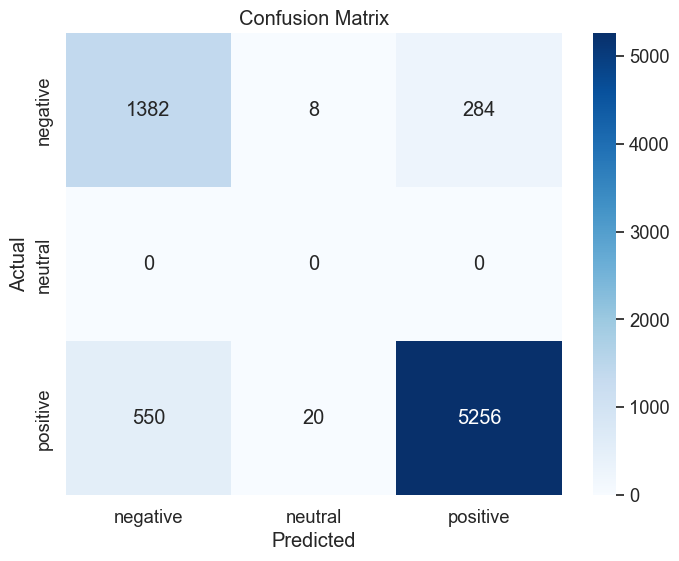

Accuracy: 0.8850666666666667
Precision: 0.8966381110837053
Recall: 0.8850666666666667
F1-score: 0.8895169284110036


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
Iter12 = data.swifter.apply(train, axis=1)
Iter12.to_csv('T12.csv')
Iter12['DTC'] = Iter12['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter12['ST']=Iter12['DTC'].swifter.apply(get_dominant_topics)
Iter12['ATW'] = Iter12.swifter.apply(get_topic_words, axis=1)
Iter12['sentiment_score'] = Iter12.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df12=calculate_reaching_definition(Iter12,'sentiment_score')
IN_sets12, OUT_sets12 = calculate_IN_OUT_sets(df12['definitions_generated'], df12['definitions_killed'])

S12 = [0] * len(OUT_sets12)
for i, out_set in enumerate(OUT_sets12):
    S12[i] = list(out_set)[-1] if out_set else None

summaries12 = generate_summary(Iter12['sentence'], S12, Iter12['sentiment_score'])
summary_df12 = pd.DataFrame({'Summary': summaries12})

Iter12['TBLabel']=Iter12['Reviews'].swifter.apply( classify_sentiment)
summary_df12['TBLabel']=summary_df12['Summary'].swifter.apply( classify_sentiment)

summary_df12.to_csv('TWLSA12.csv')

actual = Iter12['TBLabel']
predicted = summary_df12['TBLabel']
label =['negative','neutral','positive']
cm = confusion_matrix(actual, predicted)
labels = np.unique(actual)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy12 = accuracy_score(actual, predicted)
precision12 = precision_score(actual, predicted, average='weighted')
recall12 = recall_score(actual, predicted, average='weighted')
f112 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy12)
print("Precision:", precision12)
print("Recall:", recall12)
print("F1-score:", f112)

In [63]:
acc =[accuracy5,accuracy6,accuracy7,accuracy8,accuracy9,accuracy0,accuracy11,accuracy12]
pre =[precision5,precision6,precision7,precision8,precision9,precision0,precision11,precision12]
rec =[recall5,recall6,recall7,recall8,recall9,recall0,recall11,recall12]
f1s =[f15,f16,f17,f18,f19,f10,f111,f112]

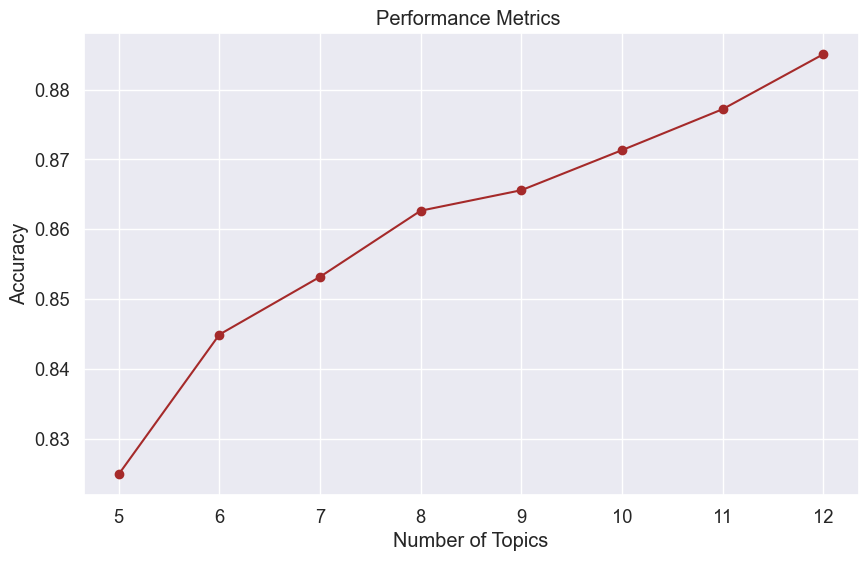

In [65]:
topics=[5,6,7,8,9,10,11,12]
plt.figure(figsize=(10, 6))
plt.plot(topics, acc, marker='o', label='Accuracy', color='brown')
plt.xlabel('Number of Topics')
plt.ylabel('Accuracy')
plt.title('Performance Metrics ')
plt.grid(True)
plt.show()


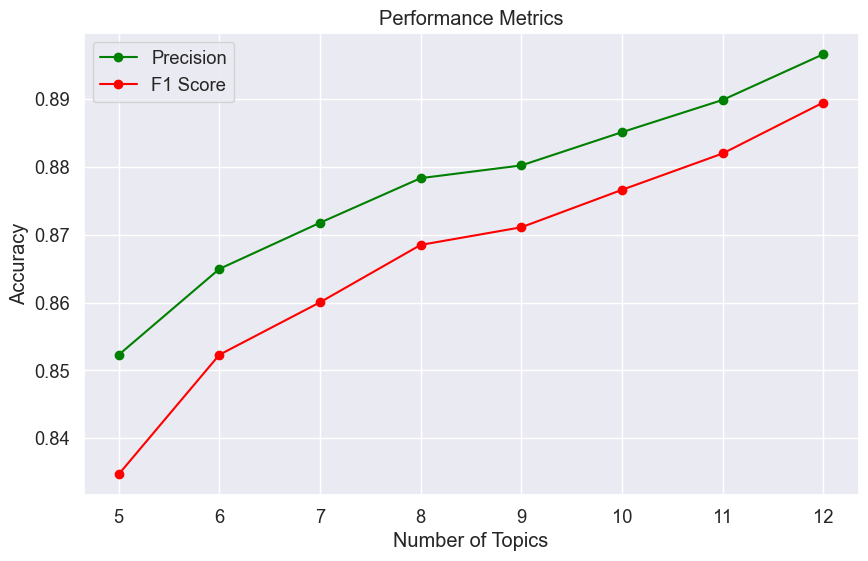

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(topics, pre, marker='o', label='Precision', color='green')
plt.plot(topics, f1s, marker='o', label='F1 Score', color='red')
plt.xlabel('Number of Topics')
plt.ylabel('Accuracy')
plt.title('Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()


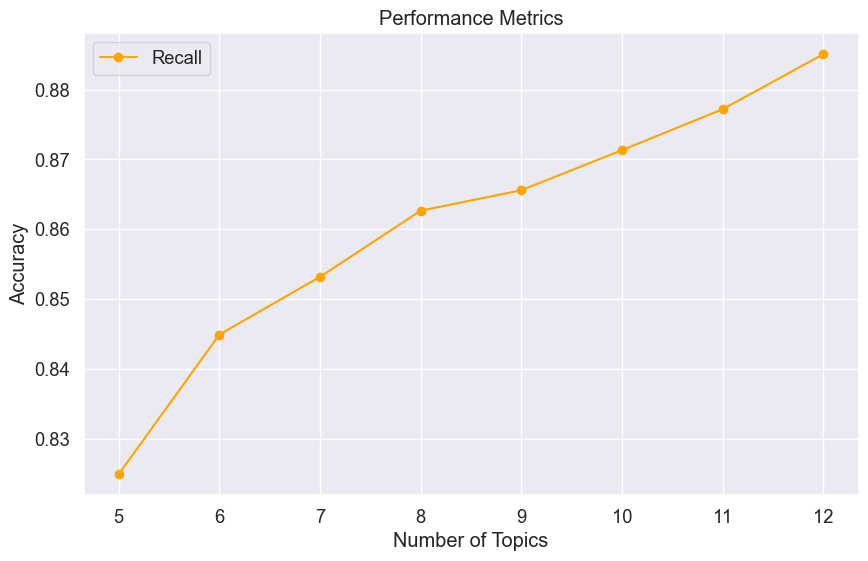

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(topics, rec, marker='o', label='Recall', color='orange')
plt.xlabel('Number of Topics')
plt.ylabel('Accuracy')
plt.title('Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()
